# Slope and intercept of size abundance relationship - Seasonal and Interannual changes

**** new approach ****

Before this, I would exclude the diazotrophs from this trend becuase they are not found in the Arctic, so they show up as a nan value that creates the whole regression a nan for the Arctic. By taking them out, we solve that problem completely, but that affected the slope of regions that did not have diazotrophs, and any other group that was not found in any other region.. 

SO.... I think I finally figured it out. I instead of making them into nan's I made them into Zeros, and instead of taking just the regular log10, I added a 1 to all of the values so if there are values that are zero's they do not affect the slopes and they just become zeros after the log. 

This solved the problem of having ot have a mask for the diazotrophs, and the slopes look a lot more like they should be looking. 

In [1]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns

# Scientific libraries
from numpy import arange,array,ones
from scipy import stats
import os
import matplotlib.gridspec as gridspec

In [2]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [3]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

## Load size abundance slope for the 62 yr period 

In [4]:
case = 'g.e21.G1850ECOIAF.t62_g17.marbl0_33.GNG595'
path = f'/glade/campaign/cesm/development/bgcwg/projects/marbl-spectra/{case}/ocn/hist'

In [5]:
variables = [f'{var}' for var in ['ECOSYS_IFRAC']]
coords = {'x':'TLONG','y':'TLAT'}
keep_vars = variables + list(coords.values())+['dz','KMT','time']

In [6]:
%%time

ds_summer_avg = xr.Dataset()
ds_spring_avg = xr.Dataset()
ds_fall_avg = xr.Dataset()
ds_winter_avg =xr.Dataset()

for year in np.arange(63,125,1):
    yr4="0{:02d}".format(year).zfill(4)
    print(year)
    
    ds_summer = xr.Dataset()
    ds_spring = xr.Dataset()
    ds_winter = xr.Dataset()
    ds_fall = xr.Dataset()

    file = sorted(glob.glob(f'{path}/{case}.pop.h.{yr4}-*.nc'))
    
    winter_indexes = [0,1,-1]
    winter_files = [file[ind] for ind in winter_indexes]
    dsv_winter=xr.open_mfdataset(winter_files, decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
    dsv_summer=xr.open_mfdataset(file[5:8], decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
    dsv_spring=xr.open_mfdataset(file[2:5], decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
    dsv_fall=xr.open_mfdataset(file[8:11], decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
    
    for vv in variables: 
        ds_summer = xr.merge((ds_summer, dsv_summer[vv]))
        ds_spring = xr.merge((ds_spring, dsv_spring[vv]))
        ds_winter = xr.merge((ds_winter, dsv_winter[vv]))
        ds_fall = xr.merge((ds_fall, dsv_fall[vv]))
        

    ds_summer = ds_summer.drop([v for v in ds_summer.variables if v not in keep_vars]).squeeze()
    ds_summer = ds_summer.mean(dim='time')
    ds_summer_avg = xr.concat([ds_summer_avg, ds_summer],dim='year')
    
    ds_spring = ds_spring.drop([v for v in ds_spring.variables if v not in keep_vars]).squeeze()
    ds_spring = ds_spring.mean(dim='time')
    ds_spring_avg = xr.concat([ds_spring_avg, ds_spring],dim='year')
    
    ds_winter = ds_winter.drop([v for v in ds_winter.variables if v not in keep_vars]).squeeze()
    ds_winter = ds_winter.mean(dim='time')
    ds_winter_avg = xr.concat([ds_winter_avg, ds_winter],dim='year')
    
    ds_fall = ds_fall.drop([v for v in ds_fall.variables if v not in keep_vars]).squeeze()
    ds_fall = ds_fall.mean(dim='time')
    ds_fall_avg = xr.concat([ds_fall_avg, ds_fall],dim='year')

63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
CPU times: user 10min 15s, sys: 45.7 s, total: 11min
Wall time: 11min 55s


In [7]:
ypp_surface_62yr = np.load('/glade/scratch/gabyn/SPECTRA/ypp_surface_62yr_try2.npy')

In [8]:
ypp_surface_62yr.shape

(63, 12, 384, 320, 5)

In [9]:
ypp_surface_62yr[ypp_surface_62yr==0]=np.nan

## GLOBAL: Winter, Spring, Summer and Fall. 

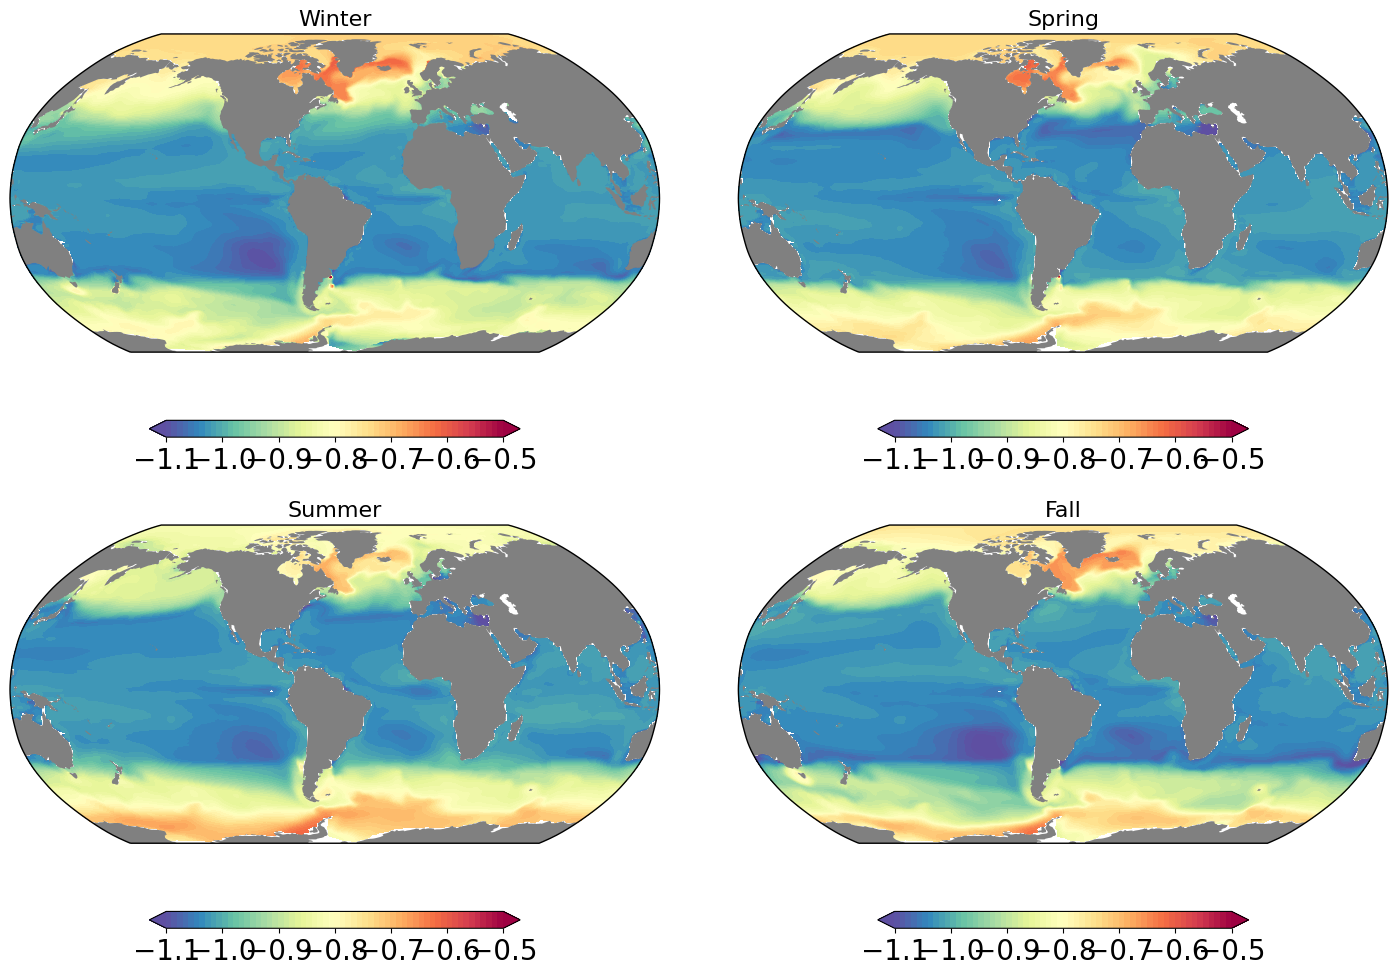

In [10]:
fig = plt.figure(figsize=(15, 10))
lat = ds_summer.TLAT
lev = np.arange(-1.1, -0.495, 0.01)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=-0.8)

## WINTER 
ax = fig.add_subplot(2, 2, 1, projection=ccrs.Robinson(central_longitude=305.0))
tlon, tlat, phyto = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, np.nanmean(ypp_surface_62yr[:,list(range(2)) + [-1],:,:,0],axis=(0,1)))
cf = ax.contourf(tlon, tlat, phyto, vmin=-1.1, vmax=-0.5,levels=lev,norm=norm, extend='both',cmap='Spectral_r',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[-1.1,-1,-0.9, -0.8,-0.7, -0.6,-0.5],shrink=0.5,orientation='horizontal')
cb.ax.tick_params(labelsize=20)
ax.set_title('Winter', fontsize =16)


## SPRING
ax = fig.add_subplot(2, 2, 2, projection=ccrs.Robinson(central_longitude=305.0))
tlon, tlat, phyto = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, np.nanmean(ypp_surface_62yr[:,2:5,:,:,0],axis=(0,1)))
cf = ax.contourf(tlon, tlat, phyto, vmin=-1.1, vmax=-0.5,levels=lev,norm=norm, extend='both',cmap='Spectral_r',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[-1.1,-1,-0.9, -0.8,-0.7, -0.6,-0.5],shrink=0.5,orientation='horizontal')
cb.ax.tick_params(labelsize=20)
ax.set_title('Spring', fontsize =16)

## SUMMER
ax = fig.add_subplot(2, 2, 3, projection=ccrs.Robinson(central_longitude=305.0))
tlon, tlat, phyto = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, np.nanmean(ypp_surface_62yr[:,5:8,:,:,0],axis=(0,1)))
cf = ax.contourf(tlon, tlat, phyto, vmin=-1.1, vmax=-0.5,levels=lev,norm=norm, extend='both',cmap='Spectral_r',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[-1.1,-1,-0.9, -0.8,-0.7, -0.6,-0.5],shrink=0.5,orientation='horizontal')
cb.ax.tick_params(labelsize=20)
ax.set_title('Summer', fontsize =16)


##FALL
ax = fig.add_subplot(2, 2, 4, projection=ccrs.Robinson(central_longitude=305.0))
tlon, tlat, phyto = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, np.nanmean(ypp_surface_62yr[:,8:11,:,:,0],axis=(0,1)))
cf = ax.contourf(tlon, tlat, phyto, vmin=-1.1, vmax=-0.5,levels=lev,norm=norm, extend='both',cmap='Spectral_r',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[-1.1,-1,-0.9, -0.8,-0.7, -0.6,-0.5],shrink=0.5,orientation='horizontal')
cb.ax.tick_params(labelsize=20)
ax.set_title('Fall', fontsize =16);
fig.tight_layout()

#fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/global_size_abundance_slope_quarterly.png',dpi=200, bbox_inches='tight')

## Arctic Region : Seasonal slope and intercept

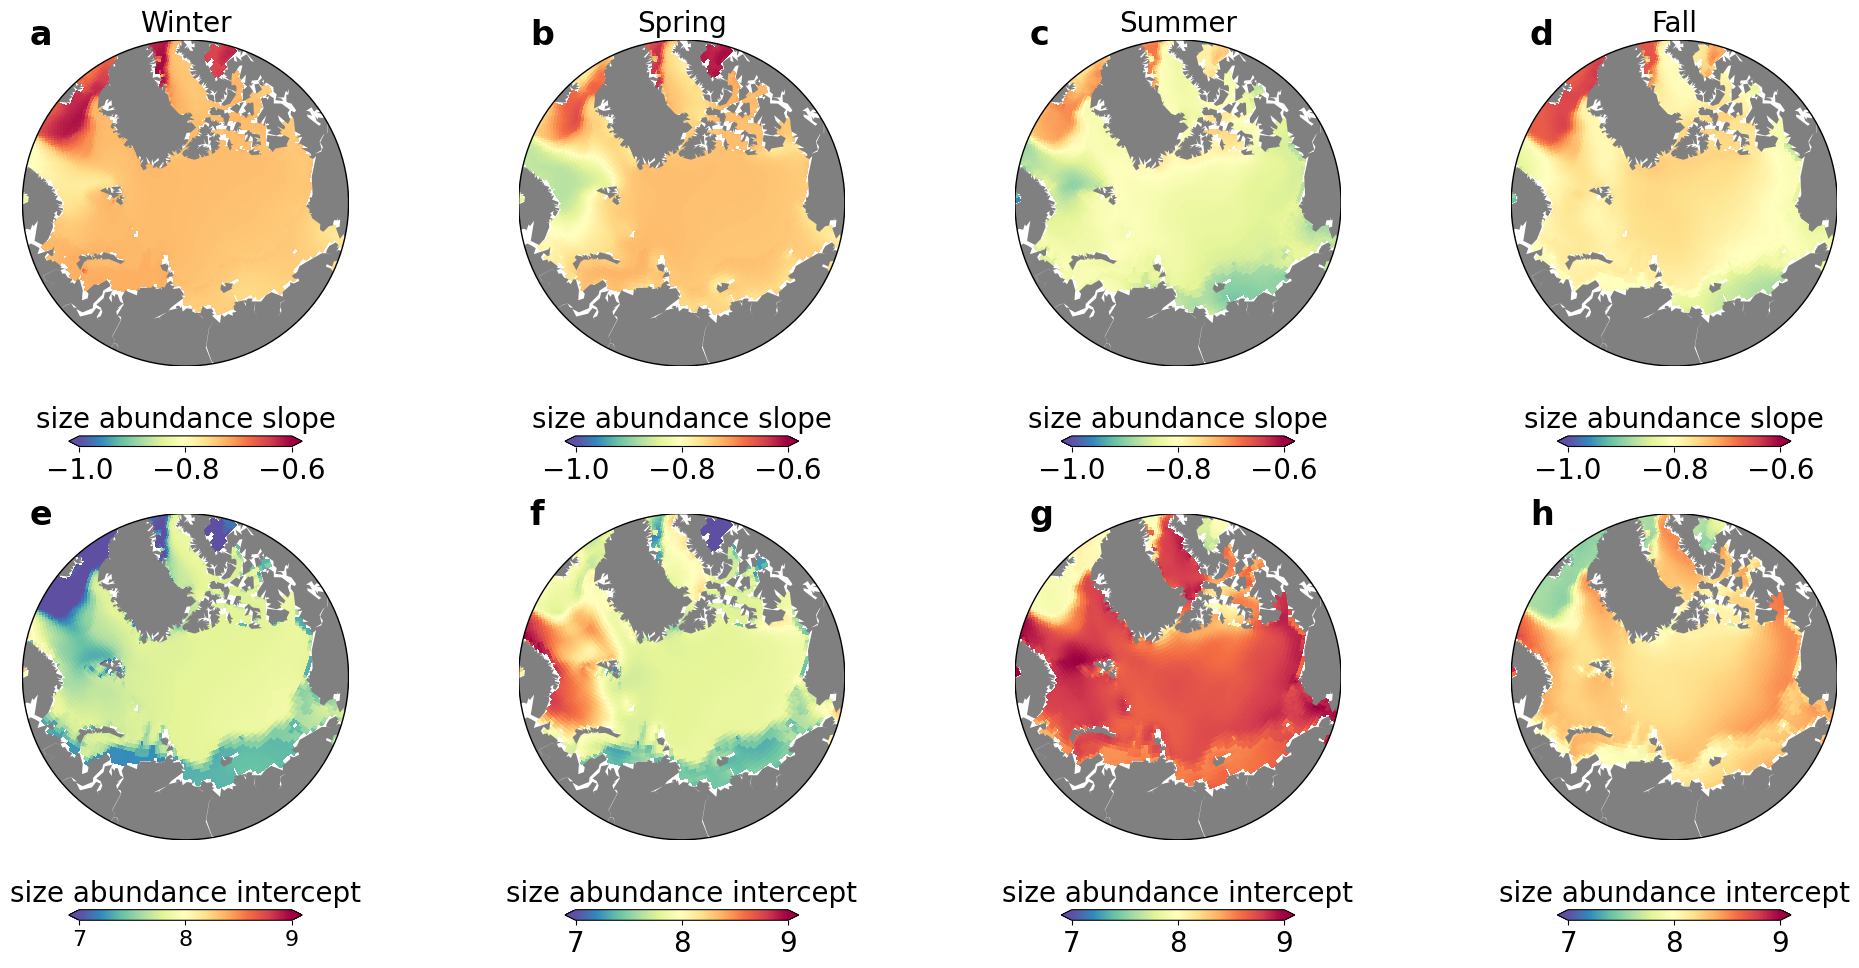

In [11]:
from mpl_toolkits.basemap import Basemap
#lev = np.arange(0, 1, 0.01)
#norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.5)
fig = plt.figure(figsize=(20, 10))

#### 62 year average!!! 

# Winter TLeq = 3 (62yr average)
ax = fig.add_subplot(2, 4, 1)
lon, lat, winter = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, np.nanmean(ypp_surface_62yr[43:63,list(range(2)) + [-1],:,:,0],axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, winter, cmap='Spectral_r', vmin = -1, vmax = -0.6);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title('size abundance slope', fontsize=20)
cb.ax.tick_params(labelsize=20)
ax.set_title('Winter', fontsize =20)

# Spring TLeq = 3, (62yr average)
ax = fig.add_subplot(2, 4, 2)
lon, lat, spring = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, np.nanmean(ypp_surface_62yr[43:63,2:5,:,:,0],axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, spring, cmap='Spectral_r', vmin = -1, vmax = -0.6);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title('size abundance slope', fontsize=20)
cb.ax.tick_params(labelsize=20)
ax.set_title('Spring', fontsize =20)

# Summer TLeq = 3, (62 yr average)
ax = fig.add_subplot(2, 4, 3)
lon, lat, summer = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, np.nanmean(ypp_surface_62yr[43:63,5:8,:,:,0],axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, summer, cmap='Spectral_r', vmin = -1, vmax = -0.6);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title('size abundance slope', fontsize=20)
cb.ax.tick_params(labelsize=20)
ax.set_title('Summer', fontsize =20)

# Fall TLeq = 3, (62 yr average)
ax = fig.add_subplot(2, 4, 4)
lon, lat, fall = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, np.nanmean(ypp_surface_62yr[43:63,8:11,:,:,0],axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, fall, cmap='Spectral_r',vmin = -1, vmax = -0.6);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title('size abundance slope', fontsize=20)
cb.ax.tick_params(labelsize=20)
ax.set_title('Fall', fontsize =20)

# Winter TLeq = 3 (62yr average)
ax = fig.add_subplot(2, 4, 5)
lon, lat, winter = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, np.nanmean(ypp_surface_62yr[43:63,list(range(2)) + [-1],:,:,1],axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, winter, cmap='Spectral_r',vmin=7,vmax=9);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title('size abundance intercept', fontsize=20)
cb.ax.tick_params(labelsize=16)

# Spring TLeq = 3, (62yr average)
ax = fig.add_subplot(2, 4, 6)
lon, lat, spring = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, np.nanmean(ypp_surface_62yr[43:63,2:5,:,:,1],axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, spring, cmap='Spectral_r',vmin=7,vmax=9);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title('size abundance intercept', fontsize=20)
cb.ax.tick_params(labelsize=20)

# Summer TLeq = 3, (62 yr average)
ax = fig.add_subplot(2, 4, 7)
lon, lat, summer = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, np.nanmean(ypp_surface_62yr[43:63,5:8,:,:,1],axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, summer, cmap='Spectral_r',vmin=7,vmax=9);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title('size abundance intercept', fontsize=20)
cb.ax.tick_params(labelsize=20)

# Fall TLeq = 3, (62 yr average)
ax = fig.add_subplot(2, 4, 8)
lon, lat, fall = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, np.nanmean(ypp_surface_62yr[43:63,8:11,:,:,1],axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, fall, cmap='Spectral_r',vmin=7,vmax=9);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title('size abundance intercept', fontsize=20)
cb.ax.tick_params(labelsize=20)
fig.text(0.05, 0.95, 'a',fontsize=24, fontweight='bold')
fig.text(0.3, 0.95, 'b',fontsize=24, fontweight='bold')
fig.text(0.55, 0.95, 'c',fontsize=24, fontweight='bold')
fig.text(0.80, 0.95, 'd',fontsize=24, fontweight='bold')
fig.text(0.05, 0.47, 'e',fontsize=24, fontweight='bold')
fig.text(0.3, 0.47, 'f',fontsize=24, fontweight='bold')
fig.text(0.55, 0.47, 'g',fontsize=24, fontweight='bold')
fig.text(0.80, 0.47, 'h',fontsize=24, fontweight='bold')
fig.tight_layout()
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/AO_size_abundance_slope&intercept_quarterly_20yrclim.png',dpi=600, bbox_inches='tight')

# Interannual Analysis

### High vs low temperature 

In [12]:
temp_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_TEMP*.nc', recursive=True))
ds_01= xr.open_mfdataset(temp_inds[0::],concat_dim='time', combine='nested') # Full 62 years of second cycle

In [13]:
temp_ds_inter = np.empty([62,12,180,360])
temp_ds_inter[:] = np.nan
x = np.array(range(0,744,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(62):
    temp_ds_inter[i,:,:,:] = ds_01.TEMP[x[i]:x[i]+12,0,:,:]

In [14]:
temp_arctic = np.nanmean(temp_ds_inter[:,:,149:180,:], axis=(2,3))
temp_arctic_anom = temp_arctic-np.nanmean(temp_arctic,axis=0)
err_ao = np.nanstd(temp_arctic_anom,axis=(0,1))

# Selecting the warm and cold years as less or more than 1/3 of standard deviation 
cold_years_arctic = np.where(np.nanmean(temp_arctic_anom,axis=1) < -(err_ao/2))
warm_years_arctic = np.where(np.nanmean(temp_arctic_anom,axis=1) > (err_ao/2))

In [15]:
cold_years = ypp_surface_62yr[cold_years_arctic,:,:,:,:] # 1/2 standard deviation 
warm_years = ypp_surface_62yr[warm_years_arctic,:,:,:,:] # 1/2 standard deviation 

### Low vs high ice years 

In [16]:
temp_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_ECOSYS_IFRAC*.nc', recursive=True))
ds_02= xr.open_mfdataset(temp_inds[0::],concat_dim='time', combine='nested') # Full 62 years of second cycle

In [17]:
ECOSYS_IFRAC_ds_inter = np.empty([62,12,180,360])
ECOSYS_IFRAC_ds_inter[:] = np.nan
x = np.array(range(0,744,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(62):
    ECOSYS_IFRAC_ds_inter[i,:,:,:] = ds_02.ECOSYS_IFRAC[x[i]:x[i]+12,:,:]

In [18]:
ice_arctic = np.nanmean(ECOSYS_IFRAC_ds_inter[:,:,149:180,:], axis=(2,3))
ice_arctic_anom = ice_arctic-np.nanmean(ice_arctic,axis=0)
err_ao = np.nanstd(ice_arctic_anom,axis=(0,1))

# Selecting the warm and cold years as less or more than 1/3 of standard deviation 
low_ice_years_arctic = np.where(np.nanmean(ice_arctic_anom,axis=1) < -(err_ao/2))
high_ice_years_arctic = np.where(np.nanmean(ice_arctic_anom,axis=1) > (err_ao/2))

In [19]:
low_ice_years = ypp_surface_62yr[low_ice_years_arctic,:,:,:,:] # 1/2 standard deviation 
high_ice_years = ypp_surface_62yr[high_ice_years_arctic,:,:,:,:] # 1/2 standard deviation 

### Low vs high nutrient years

In [20]:
NO3_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_NO3*.nc', recursive=True))
ds_03= xr.open_mfdataset(NO3_inds[0::],concat_dim='time', combine='nested') # Full 62 years of second cycle

In [21]:
NO3_ds_inter = np.empty([62,12,180,360])
NO3_ds_inter[:] = np.nan
x = np.array(range(0,744,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(62):
    NO3_ds_inter[i,:,:,:] = ds_03.NO3[x[i]:x[i]+12,0,:,:]

In [22]:
no3_arctic = np.nanmean(NO3_ds_inter[:,:,149:180,:], axis=(2,3))
no3_arctic_anom = no3_arctic-np.nanmean(no3_arctic,axis=0)
err_ao = np.nanstd(no3_arctic_anom,axis=(0,1))

# Selecting the warm and cold years as less or more than 1/3 of standard deviation 
low_no3_years_arctic = np.where(np.nanmean(no3_arctic_anom,axis=1) < -(err_ao/2))
high_no3_years_arctic = np.where(np.nanmean(no3_arctic_anom,axis=1) > (err_ao/2))

In [23]:
low_no3_years = ypp_surface_62yr[low_no3_years_arctic,:,:,:,:] # 1/2 standard deviation 
high_no3_years = ypp_surface_62yr[high_no3_years_arctic,:,:,:,:] # 1/2 standard deviation 

## Ice Fraction

In [24]:
ice_frac_summer = np.array(ds_summer_avg.ECOSYS_IFRAC)
ice_frac_winter = np.array(ds_winter_avg.ECOSYS_IFRAC)
ice_frac_fall = np.array(ds_fall_avg.ECOSYS_IFRAC)
ice_frac_spring = np.array(ds_spring_avg.ECOSYS_IFRAC)

In [25]:
## NO3
low_no3_years_summer_ice = ice_frac_summer[low_no3_years_arctic,:,:] # 1/2 standard deviation 
high_no3_years_summer_ice = ice_frac_summer[high_no3_years_arctic,:,:] # 1/2 standard deviation 

low_no3_years_spring_ice = ice_frac_spring[low_no3_years_arctic,:,:] # 1/2 standard deviation 
high_no3_years_spring_ice= ice_frac_spring[high_no3_years_arctic,:,:] # 1/2 standard deviation 

low_no3_years_fall_ice = ice_frac_fall[low_no3_years_arctic,:,:] # 1/2 standard deviation 
high_no3_years_fall_ice = ice_frac_fall[high_no3_years_arctic,:,:] # 1/2 standard deviation 

low_no3_years_winter_ice = ice_frac_winter[low_no3_years_arctic,:,:] # 1/2 standard deviation 
high_no3_years_winter_ice = ice_frac_winter[high_no3_years_arctic,:,:] # 1/2 standard deviation 

## ice
low_ice_years_summer_ice = ice_frac_summer[low_ice_years_arctic,:,:] # 1/2 standard deviation 
high_ice_years_summer_ice = ice_frac_summer[high_ice_years_arctic,:,:] # 1/2 standard deviation 

low_ice_years_spring_ice = ice_frac_spring[low_ice_years_arctic,:,:] # 1/2 standard deviation 
high_ice_years_spring_ice= ice_frac_spring[high_ice_years_arctic,:,:] # 1/2 standard deviation 

low_ice_years_fall_ice = ice_frac_fall[low_ice_years_arctic,:,:] # 1/2 standard deviation 
high_ice_years_fall_ice = ice_frac_fall[high_ice_years_arctic,:,:] # 1/2 standard deviation 

low_ice_years_winter_ice = ice_frac_winter[low_ice_years_arctic,:,:] # 1/2 standard deviation 
high_ice_years_winter_ice = ice_frac_winter[high_ice_years_arctic,:,:] # 1/2 standard deviation 

## temperature
low_temp_years_summer_ice = ice_frac_summer[cold_years_arctic,:,:] # 1/2 standard deviation 
high_temp_years_summer_ice = ice_frac_summer[warm_years_arctic,:,:] # 1/2 standard deviation 

low_temp_years_spring_ice = ice_frac_spring[cold_years_arctic,:,:] # 1/2 standard deviation 
high_temp_years_spring_ice= ice_frac_spring[warm_years_arctic,:,:] # 1/2 standard deviation 

low_temp_years_fall_ice = ice_frac_fall[cold_years_arctic,:,:] # 1/2 standard deviation 
high_temp_years_fall_ice = ice_frac_fall[warm_years_arctic,:,:] # 1/2 standard deviation 

low_temp_years_winter_ice = ice_frac_winter[cold_years_arctic,:,:] # 1/2 standard deviation 
high_temp_years_winter_ice = ice_frac_winter[warm_years_arctic,:,:] # 1/2 standard deviation 

## Publication ready figure

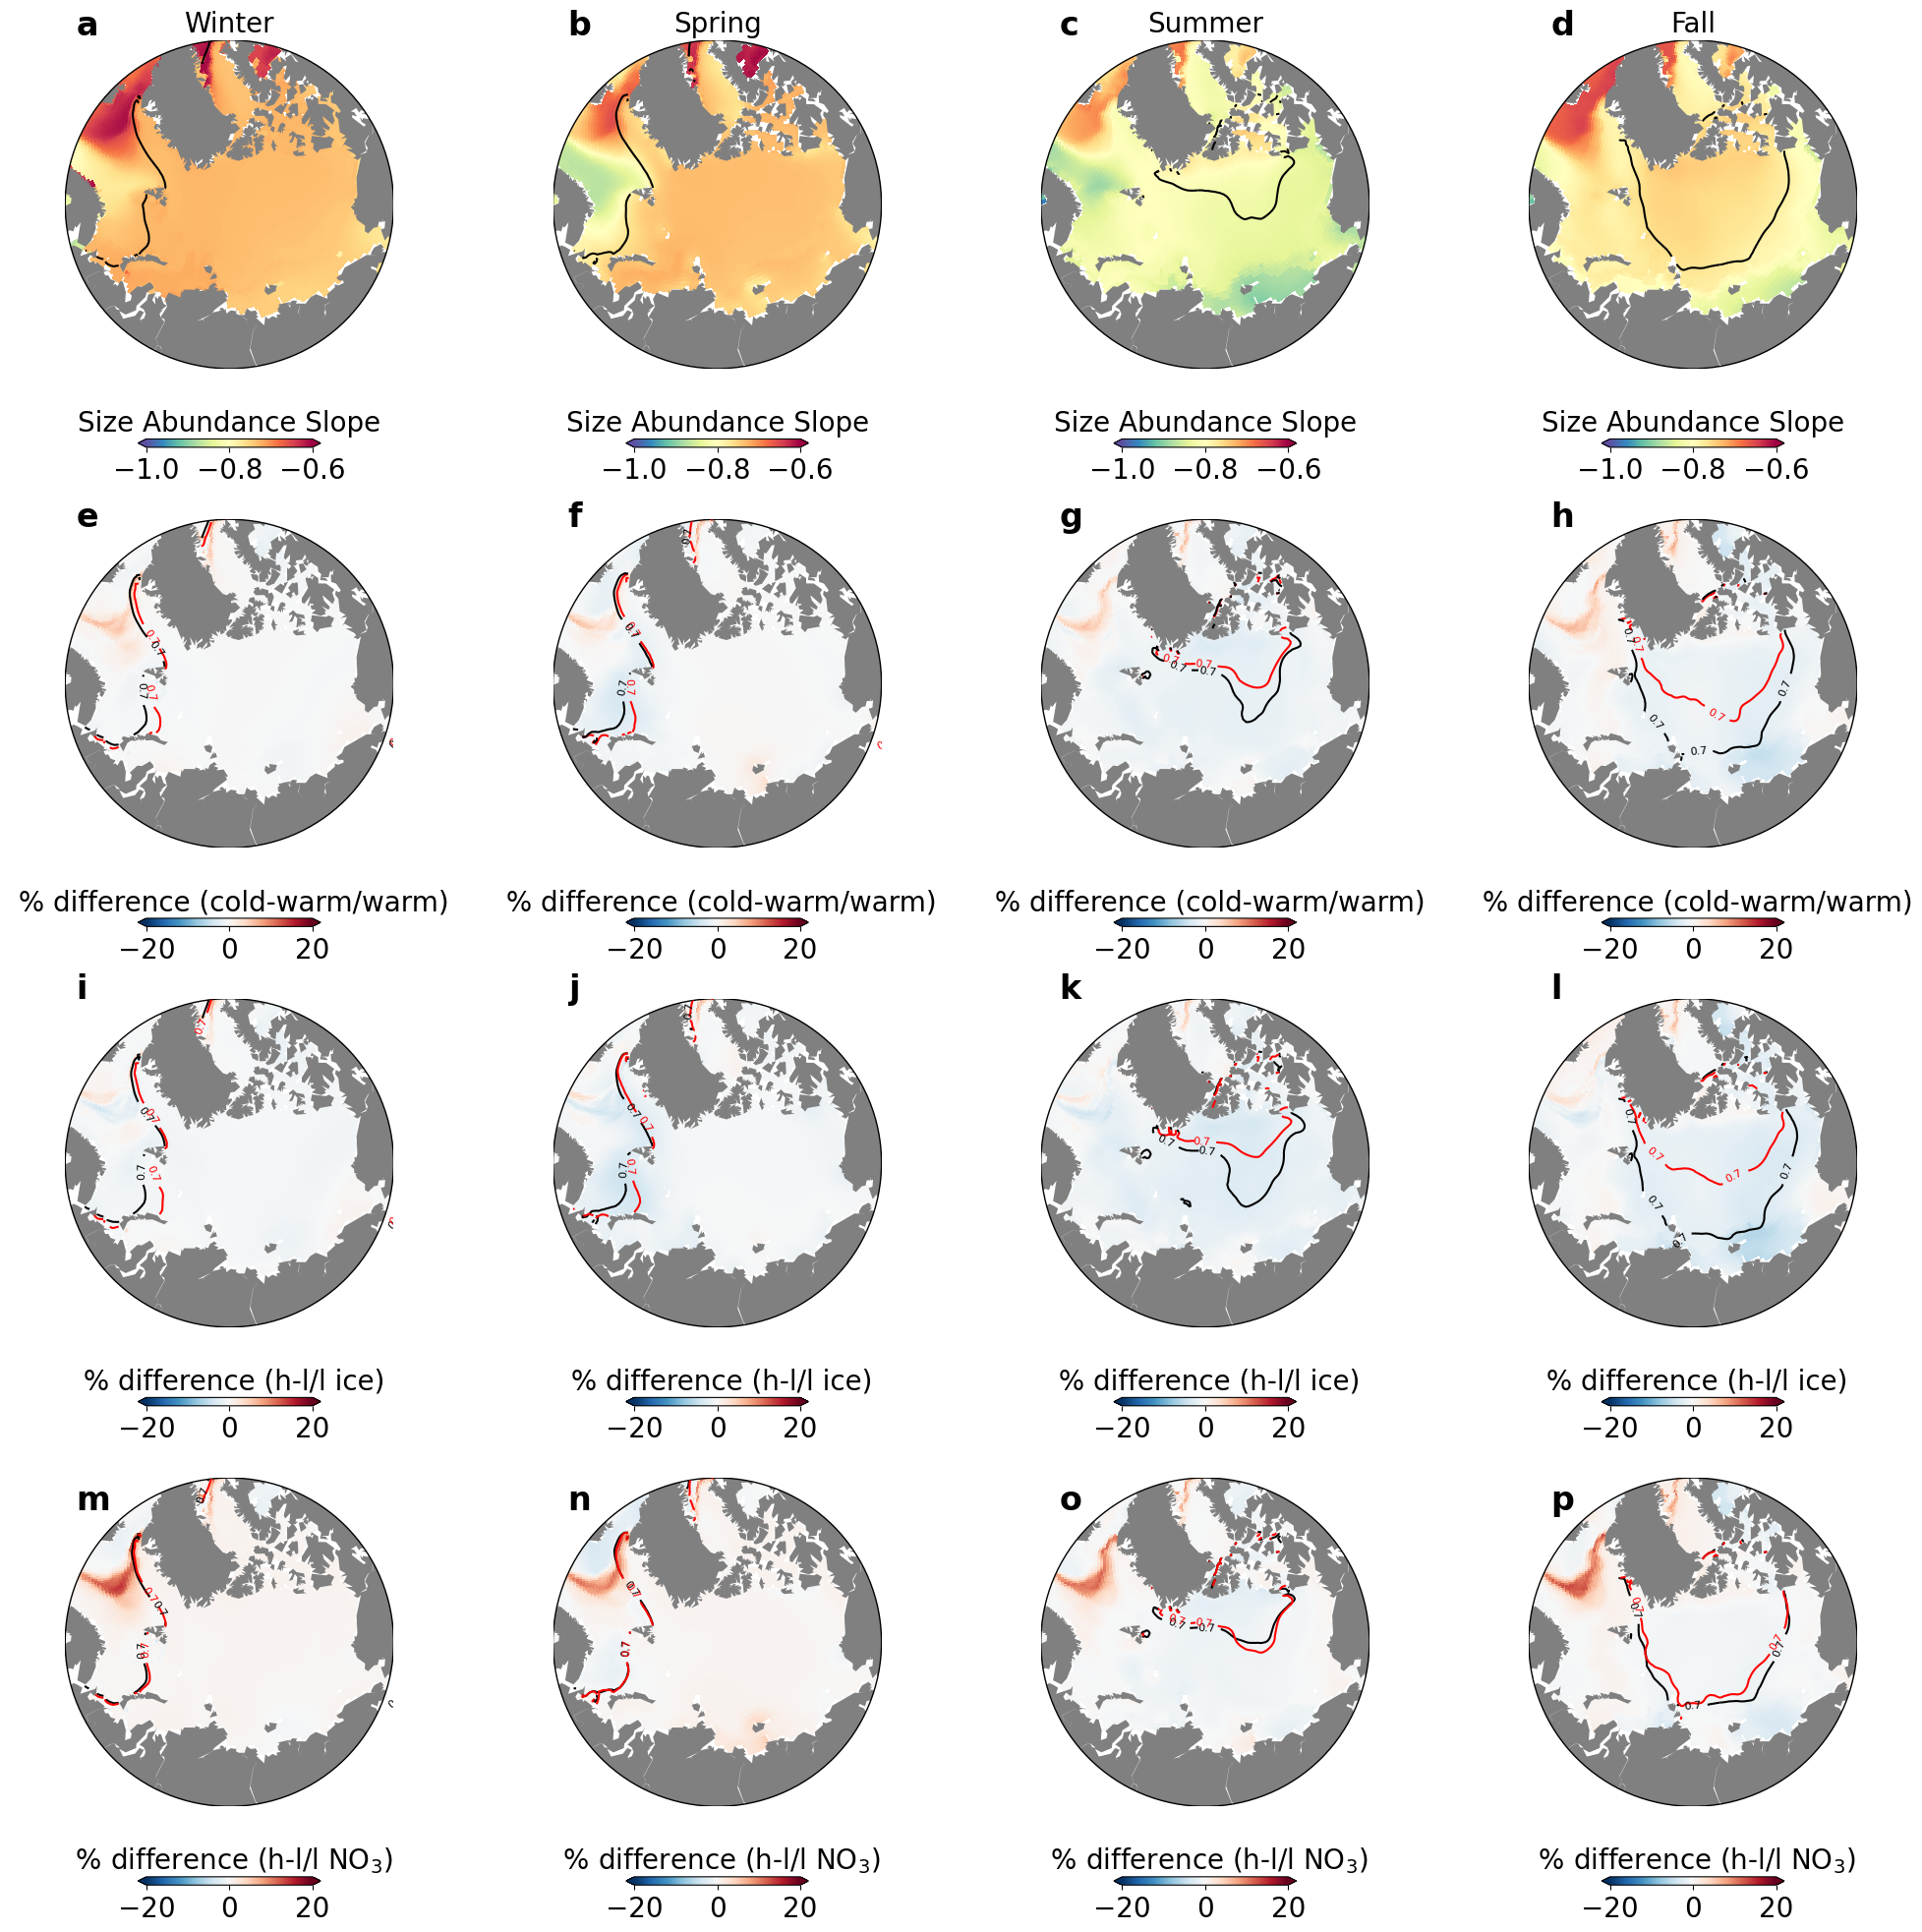

In [27]:
from mpl_toolkits.basemap import Basemap
lev = np.arange(0, 1, 0.01)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.5)
fig = plt.figure(figsize=(20, 20))

# ------------------------------------------------
########## Seasonal Changes #############
# ------------------------------------------------
#  62-year average 

# Winter TLeq = 3 (62yr average)
ax = fig.add_subplot(4, 4, 1)
lon, lat, winter = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, np.nanmean(ypp_surface_62yr[:,list(range(2)) + [-1],:,:,0],axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, winter, cmap='Spectral_r', vmin = -1, vmax = -0.6);
tlon, tlat, winter_ice = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(ds_winter_avg.ECOSYS_IFRAC, axis=0))
cs = m.contour(x, y, winter_ice,levels = [0.7],colors='k');
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title('Size Abundance Slope', fontsize=20)
cb.ax.tick_params(labelsize=20)
ax.set_title('Winter', fontsize =20)

# Spring TLeq = 3, (62yr average)
ax = fig.add_subplot(4, 4, 2)
lon, lat, spring = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, np.nanmean(ypp_surface_62yr[:,2:5,:,:,0],axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, spring, cmap='Spectral_r', vmin = -1, vmax = -0.6);
tlon, tlat, spring_ice = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(ds_spring_avg.ECOSYS_IFRAC, axis=0))
cs = m.contour(x, y, spring_ice,levels = [0.7],colors='k');
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title('Size Abundance Slope', fontsize=20)
cb.ax.tick_params(labelsize=20)
ax.set_title('Spring', fontsize =20)

# Summer TLeq = 3, (62 yr average)
ax = fig.add_subplot(4, 4, 3)
lon, lat, summer = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, np.nanmean(ypp_surface_62yr[:,5:8,:,:,0],axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, summer, cmap='Spectral_r', vmin = -1, vmax = -0.6);
tlon, tlat, summer_ice = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(ds_summer_avg.ECOSYS_IFRAC, axis=0))
cs = m.contour(x, y, summer_ice,levels = [0.7],colors='k');
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title('Size Abundance Slope', fontsize=20)
cb.ax.tick_params(labelsize=20)
ax.set_title('Summer', fontsize =20)

# Fall TLeq = 3, (62 yr average)
ax = fig.add_subplot(4, 4, 4)
lon, lat, fall = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, np.nanmean(ypp_surface_62yr[:,8:11,:,:,0],axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, fall, cmap='Spectral_r',vmin = -1, vmax = -0.6);
tlon, tlat, fall_ice = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(ds_fall_avg.ECOSYS_IFRAC, axis=0))
cs = m.contour(x, y, fall_ice,levels = [0.7],colors='k');
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title('Size Abundance Slope', fontsize=20)
cb.ax.tick_params(labelsize=20)
ax.set_title('Fall', fontsize =20)

# ------------------------------------------------
########## Interannual differences #############
# ------------------------------------------------


# Winter, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 5)
winter_temp_diff = ((np.nanmean(cold_years[:,:,list(range(2)) + [-1],:,:,0], axis=(0,1,2))-np.nanmean(warm_years[:,:,list(range(2)) + [-1],:,:,0], axis=(0,1,2)))/np.nanmean(warm_years[:,:,list(range(2)) + [-1],:,:,0], axis=(0,1,2)))*100
lon, lat, w_diff = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, winter_temp_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=-20,vmax=20);
tlon, tlat, winter_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_temp_years_winter_ice,axis=(0,1)))
tlon, tlat, winter_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_temp_years_winter_ice,axis=(0,1)))
cs = m.contour(x, y, winter_ice_high,levels = [0.7],colors='red'); # Red is ice fraction in warmer years (so it would be lower ice fraction). 
css = m.contour(x, y, winter_ice_low,levels = [0.7],colors='k'); # Black is ice fraction in colder years (so it would be higher ice fraction). 
lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
lb = plt.clabel(css, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (cold-warm/warm)', fontsize=20)
cb.ax.tick_params(labelsize=20)

# Spring, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 6)
spring_temp_diff = ((np.nanmean(cold_years[:,:,2:5,:,:,0], axis=(0,1,2))-np.nanmean(warm_years[:,:,2:5,:,:,0], axis=(0,1,2)))/np.nanmean(warm_years[:,:,2:5,:,:,0], axis=(0,1,2)))*100
lon, lat, sp_diff = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, spring_temp_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=-20,vmax=20);
tlon, tlat, spring_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_temp_years_spring_ice,axis=(0,1)))
tlon, tlat, spring_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_temp_years_spring_ice,axis=(0,1)))
cs = m.contour(x, y, spring_ice_high,levels = [0.7],colors='red'); # Red is ice fraction in warmer years (so it would be lower ice fraction). 
css = m.contour(x, y, spring_ice_low,levels = [0.7],colors='k'); # Black is ice fraction in colder years (so it would be higher ice fraction). 
lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
lb = plt.clabel(css, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (cold-warm/warm)', fontsize=20)
cb.ax.tick_params(labelsize=20)

# Summer, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 7)
summer_temp_diff = ((np.nanmean(cold_years[:,:,5:8,:,:,0], axis=(0,1,2))-np.nanmean(warm_years[:,:,5:8,:,:,0], axis=(0,1,2)))/np.nanmean(warm_years[:,:,5:8,:,:,0], axis=(0,1,2)))*100
lon, lat, s_diff = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, summer_temp_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=-20,vmax=20);
tlon, tlat, summer_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_temp_years_summer_ice,axis=(0,1)))
tlon, tlat, summer_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_temp_years_summer_ice,axis=(0,1)))
cs = m.contour(x, y, summer_ice_high,levels = [0.7],colors='red'); # Red is ice fraction in warmer years (so it would be lower ice fraction). 
css = m.contour(x, y, summer_ice_low,levels = [0.7],colors='k'); # Black is ice fraction in colder years (so it would be higher ice fraction). 
lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
lb = plt.clabel(css, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (cold-warm/warm)', fontsize=20)
cb.ax.tick_params(labelsize=20)

# Fall, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 8)
fall_temp_diff = ((np.nanmean(cold_years[:,:,8:11,:,:,0], axis=(0,1,2))-np.nanmean(warm_years[:,:,8:11,:,:,0], axis=(0,1,2)))/np.nanmean(warm_years[:,:,8:11,:,:,0], axis=(0,1,2)))*100
lon, lat, f_diff = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, fall_temp_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=-20,vmax=20);
tlon, tlat, fall_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_temp_years_fall_ice,axis=(0,1)))
tlon, tlat, fall_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_temp_years_fall_ice,axis=(0,1)))
cs = m.contour(x, y, fall_ice_high,levels = [0.7],colors='red'); # Red is ice fraction in warmer years (so it would be lower ice fraction). 
css = m.contour(x, y, fall_ice_low,levels = [0.7],colors='k'); # Black is ice fraction in colder years (so it would be higher ice fraction). 
lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
lb = plt.clabel(css, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (cold-warm/warm)', fontsize=20)
cb.ax.tick_params(labelsize=20)

## Ice Fraction

# Winter, % difference of catch from high and low ice fraction  years. 
ax = fig.add_subplot(4, 4, 9)
winter_ice_diff = ((np.nanmean(high_ice_years[:,:,list(range(2)) + [-1],:,:,0], axis=(0,1,2))-np.nanmean(low_ice_years[:,:,list(range(2)) + [-1],:,:,0], axis=(0,1,2)))/np.nanmean(low_ice_years[:,:,list(range(2)) + [-1],:,:,0], axis=(0,1,2)))*100
lon, lat, w_diff = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, winter_ice_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=-20,vmax=20);
tlon, tlat, winter_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_ice_years_winter_ice,axis=(0,1)))
tlon, tlat, winter_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_ice_years_winter_ice,axis=(0,1)))
cs = m.contour(x, y, winter_ice_high,levels = [0.7],colors='k'); # ice in high ice years 
css = m.contour(x, y, winter_ice_low,levels = [0.7],colors='red'); # ice in low ice years 
lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
lb = plt.clabel(css, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (h-l/l ice)', fontsize=20)
cb.ax.tick_params(labelsize=20)

# Spring, % difference of catch from high and low ice fraction years. 
ax = fig.add_subplot(4, 4, 10)
spring_ice_diff = ((np.nanmean(high_ice_years[:,:,2:5,:,:,0], axis=(0,1,2))-np.nanmean(low_ice_years[:,:,2:5,:,:,0], axis=(0,1,2)))/np.nanmean(low_ice_years[:,:,2:5,:,:,0], axis=(0,1,2)))*100
lon, lat, sp_diff = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, spring_ice_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=-20,vmax=20);
tlon, tlat, spring_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_ice_years_spring_ice,axis=(0,1)))
tlon, tlat, spring_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_ice_years_spring_ice,axis=(0,1)))
cs = m.contour(x, y, spring_ice_high,levels = [0.7],colors='k'); # ice in high ice years 
css = m.contour(x, y, spring_ice_low,levels = [0.7],colors='red'); # ice in low ice years 
lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
lb = plt.clabel(css, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (h-l/l ice)', fontsize=20)
cb.ax.tick_params(labelsize=20)

# Summer, % difference of catch from high and low ice fraction  years. 
ax = fig.add_subplot(4, 4, 11)
summer_ice_diff = ((np.nanmean(high_ice_years[:,:,5:8,:,:,0], axis=(0,1,2))-np.nanmean(low_ice_years[:,:,5:8,:,:,0], axis=(0,1,2)))/np.nanmean(low_ice_years[:,:,5:8,:,:,0], axis=(0,1,2)))*100
lon, lat, s_diff = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, summer_ice_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=-20,vmax=20);
tlon, tlat, summer_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_ice_years_summer_ice,axis=(0,1)))
tlon, tlat, summer_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_ice_years_summer_ice,axis=(0,1)))
cs = m.contour(x, y, summer_ice_high,levels = [0.7],colors='k'); # ice in high ice years 
css = m.contour(x, y, summer_ice_low,levels = [0.7],colors='red'); # ice in low ice years 
lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
lb = plt.clabel(css, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (h-l/l ice)', fontsize=20)
cb.ax.tick_params(labelsize=20)

# Fall, % difference of catch from high and low ice fraction  years. 
ax = fig.add_subplot(4, 4, 12)
fall_ice_diff = ((np.nanmean(high_ice_years[:,:,8:11,:,:,0], axis=(0,1,2))-np.nanmean(low_ice_years[:,:,8:11,:,:,0], axis=(0,1,2)))/np.nanmean(low_ice_years[:,:,8:11,:,:,0], axis=(0,1,2)))*100
lon, lat, f_diff = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, fall_ice_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=-20,vmax=20);
tlon, tlat, fall_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_ice_years_fall_ice,axis=(0,1)))
tlon, tlat, fall_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_ice_years_fall_ice,axis=(0,1)))
cs = m.contour(x, y, fall_ice_high,levels = [0.7],colors='k'); # ice in high ice years 
css = m.contour(x, y, fall_ice_low,levels = [0.7],colors='red'); # ice in low ice years 
lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
lb = plt.clabel(css, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (h-l/l ice)', fontsize=20)
cb.ax.tick_params(labelsize=20)


# Winter, % difference of catch from high and low NO$_3$  years. 
ax = fig.add_subplot(4, 4, 13)
winter_no3_diff = ((np.nanmean(high_no3_years[:,:,list(range(2)) + [-1],:,:,0], axis=(0,1,2))-np.nanmean(low_no3_years[:,:,list(range(2)) + [-1],:,:,0], axis=(0,1,2)))/np.nanmean(low_no3_years[:,:,list(range(2)) + [-1],:,:,0], axis=(0,1,2)))*100
lon, lat, w_diff = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, winter_no3_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=-20,vmax=20);
tlon, tlat, winter_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_no3_years_winter_ice,axis=(0,1)))
tlon, tlat, winter_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_no3_years_winter_ice,axis=(0,1)))
cs = m.contour(x, y, winter_ice_high,levels = [0.7],colors='k'); # ice in high no3 years 
css = m.contour(x, y, winter_ice_low,levels = [0.7],colors='red'); # ice in low no3 years 
lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
lb = plt.clabel(css, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (h-l/l NO$_3$)', fontsize=20)
cb.ax.tick_params(labelsize=20)

# Spring, % difference of catch from high and low NO$_3$ years. 
ax = fig.add_subplot(4, 4, 14)
spring_no3_diff = ((np.nanmean(high_no3_years[:,:,2:5,:,:,0], axis=(0,1,2))-np.nanmean(low_no3_years[:,:,2:5,:,:,0], axis=(0,1,2)))/np.nanmean(low_no3_years[:,:,2:5,:,:,0], axis=(0,1,2)))*100
lon, lat, sp_diff = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, spring_no3_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=-20,vmax=20);
tlon, tlat, spring_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_no3_years_spring_ice,axis=(0,1)))
tlon, tlat, spring_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_no3_years_spring_ice,axis=(0,1)))
cs = m.contour(x, y, spring_ice_high,levels = [0.7],colors='k'); # ice in high no3 years 
css = m.contour(x, y, spring_ice_low,levels = [0.7],colors='red'); # ice in low no3 years 
lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
lb = plt.clabel(css, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (h-l/l NO$_3$)', fontsize=20)
cb.ax.tick_params(labelsize=20)

# Summer, % difference of catch from high and low NO$_3$  years. 
ax = fig.add_subplot(4, 4, 15)
summer_no3_diff = ((np.nanmean(high_no3_years[:,:,5:8,:,:,0], axis=(0,1,2))-np.nanmean(low_no3_years[:,:,5:8,:,:,0], axis=(0,1,2)))/np.nanmean(low_no3_years[:,:,5:8,:,:,0], axis=(0,1,2)))*100
lon, lat, s_diff = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, summer_no3_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=-20,vmax=20);
tlon, tlat, summer_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_no3_years_summer_ice,axis=(0,1)))
tlon, tlat, summer_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_no3_years_summer_ice,axis=(0,1)))
cs = m.contour(x, y, summer_ice_high,levels = [0.7],colors='k'); # ice in high no3 years 
css = m.contour(x, y, summer_ice_low,levels = [0.7],colors='red'); # ice in low no3 years 
lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
lb = plt.clabel(css, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (h-l/l NO$_3$)', fontsize=20)
cb.ax.tick_params(labelsize=20)

# Fall, % difference of catch from high and low NO$_3$  years. 
ax = fig.add_subplot(4, 4, 16)
fall_no3_diff = ((np.nanmean(high_no3_years[:,:,8:11,:,:,0], axis=(0,1,2))-np.nanmean(low_no3_years[:,:,8:11,:,:,0], axis=(0,1,2)))/np.nanmean(low_no3_years[:,:,8:11,:,:,0], axis=(0,1,2)))*100
lon, lat, f_diff = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, fall_no3_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=-20,vmax=20);
tlon, tlat, fall_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_no3_years_fall_ice,axis=(0,1)))
tlon, tlat, fall_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_no3_years_fall_ice,axis=(0,1)))
cs = m.contour(x, y, fall_ice_high,levels = [0.7],colors='k'); # ice in high no3 years 
css = m.contour(x, y, fall_ice_low,levels = [0.7],colors='red'); # ice in low no3 years 
lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
lb = plt.clabel(css, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.tick_params(labelsize=20)
cb.ax.set_title(' % difference (h-l/l NO$_3$)', fontsize=20)

fig.text(0.05, 0.98, 'a',fontsize=24, fontweight='bold')
fig.text(0.3, 0.98, 'b',fontsize=24, fontweight='bold')
fig.text(0.55, 0.98, 'c',fontsize=24, fontweight='bold')
fig.text(0.80, 0.98, 'd',fontsize=24, fontweight='bold')
fig.text(0.05, 0.73, 'e',fontsize=24, fontweight='bold')
fig.text(0.3, 0.73, 'f',fontsize=24, fontweight='bold')
fig.text(0.55, 0.73, 'g',fontsize=24, fontweight='bold')
fig.text(0.80, 0.73, 'h',fontsize=24, fontweight='bold')
fig.text(0.05, 0.49, 'i',fontsize=24, fontweight='bold')
fig.text(0.3, 0.49, 'j',fontsize=24, fontweight='bold')
fig.text(0.55, 0.49, 'k',fontsize=24, fontweight='bold')
fig.text(0.80, 0.49, 'l',fontsize=24, fontweight='bold')
fig.text(0.05, 0.23, 'm',fontsize=24, fontweight='bold')
fig.text(0.3, 0.23, 'n',fontsize=24, fontweight='bold')
fig.text(0.55, 0.23, 'o',fontsize=24, fontweight='bold')
fig.text(0.80, 0.23, 'p',fontsize=24, fontweight='bold')

plt.tight_layout()

fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/quarterly_size_abundance_slope_interannual.png',dpi=600, bbox_inches='tight')

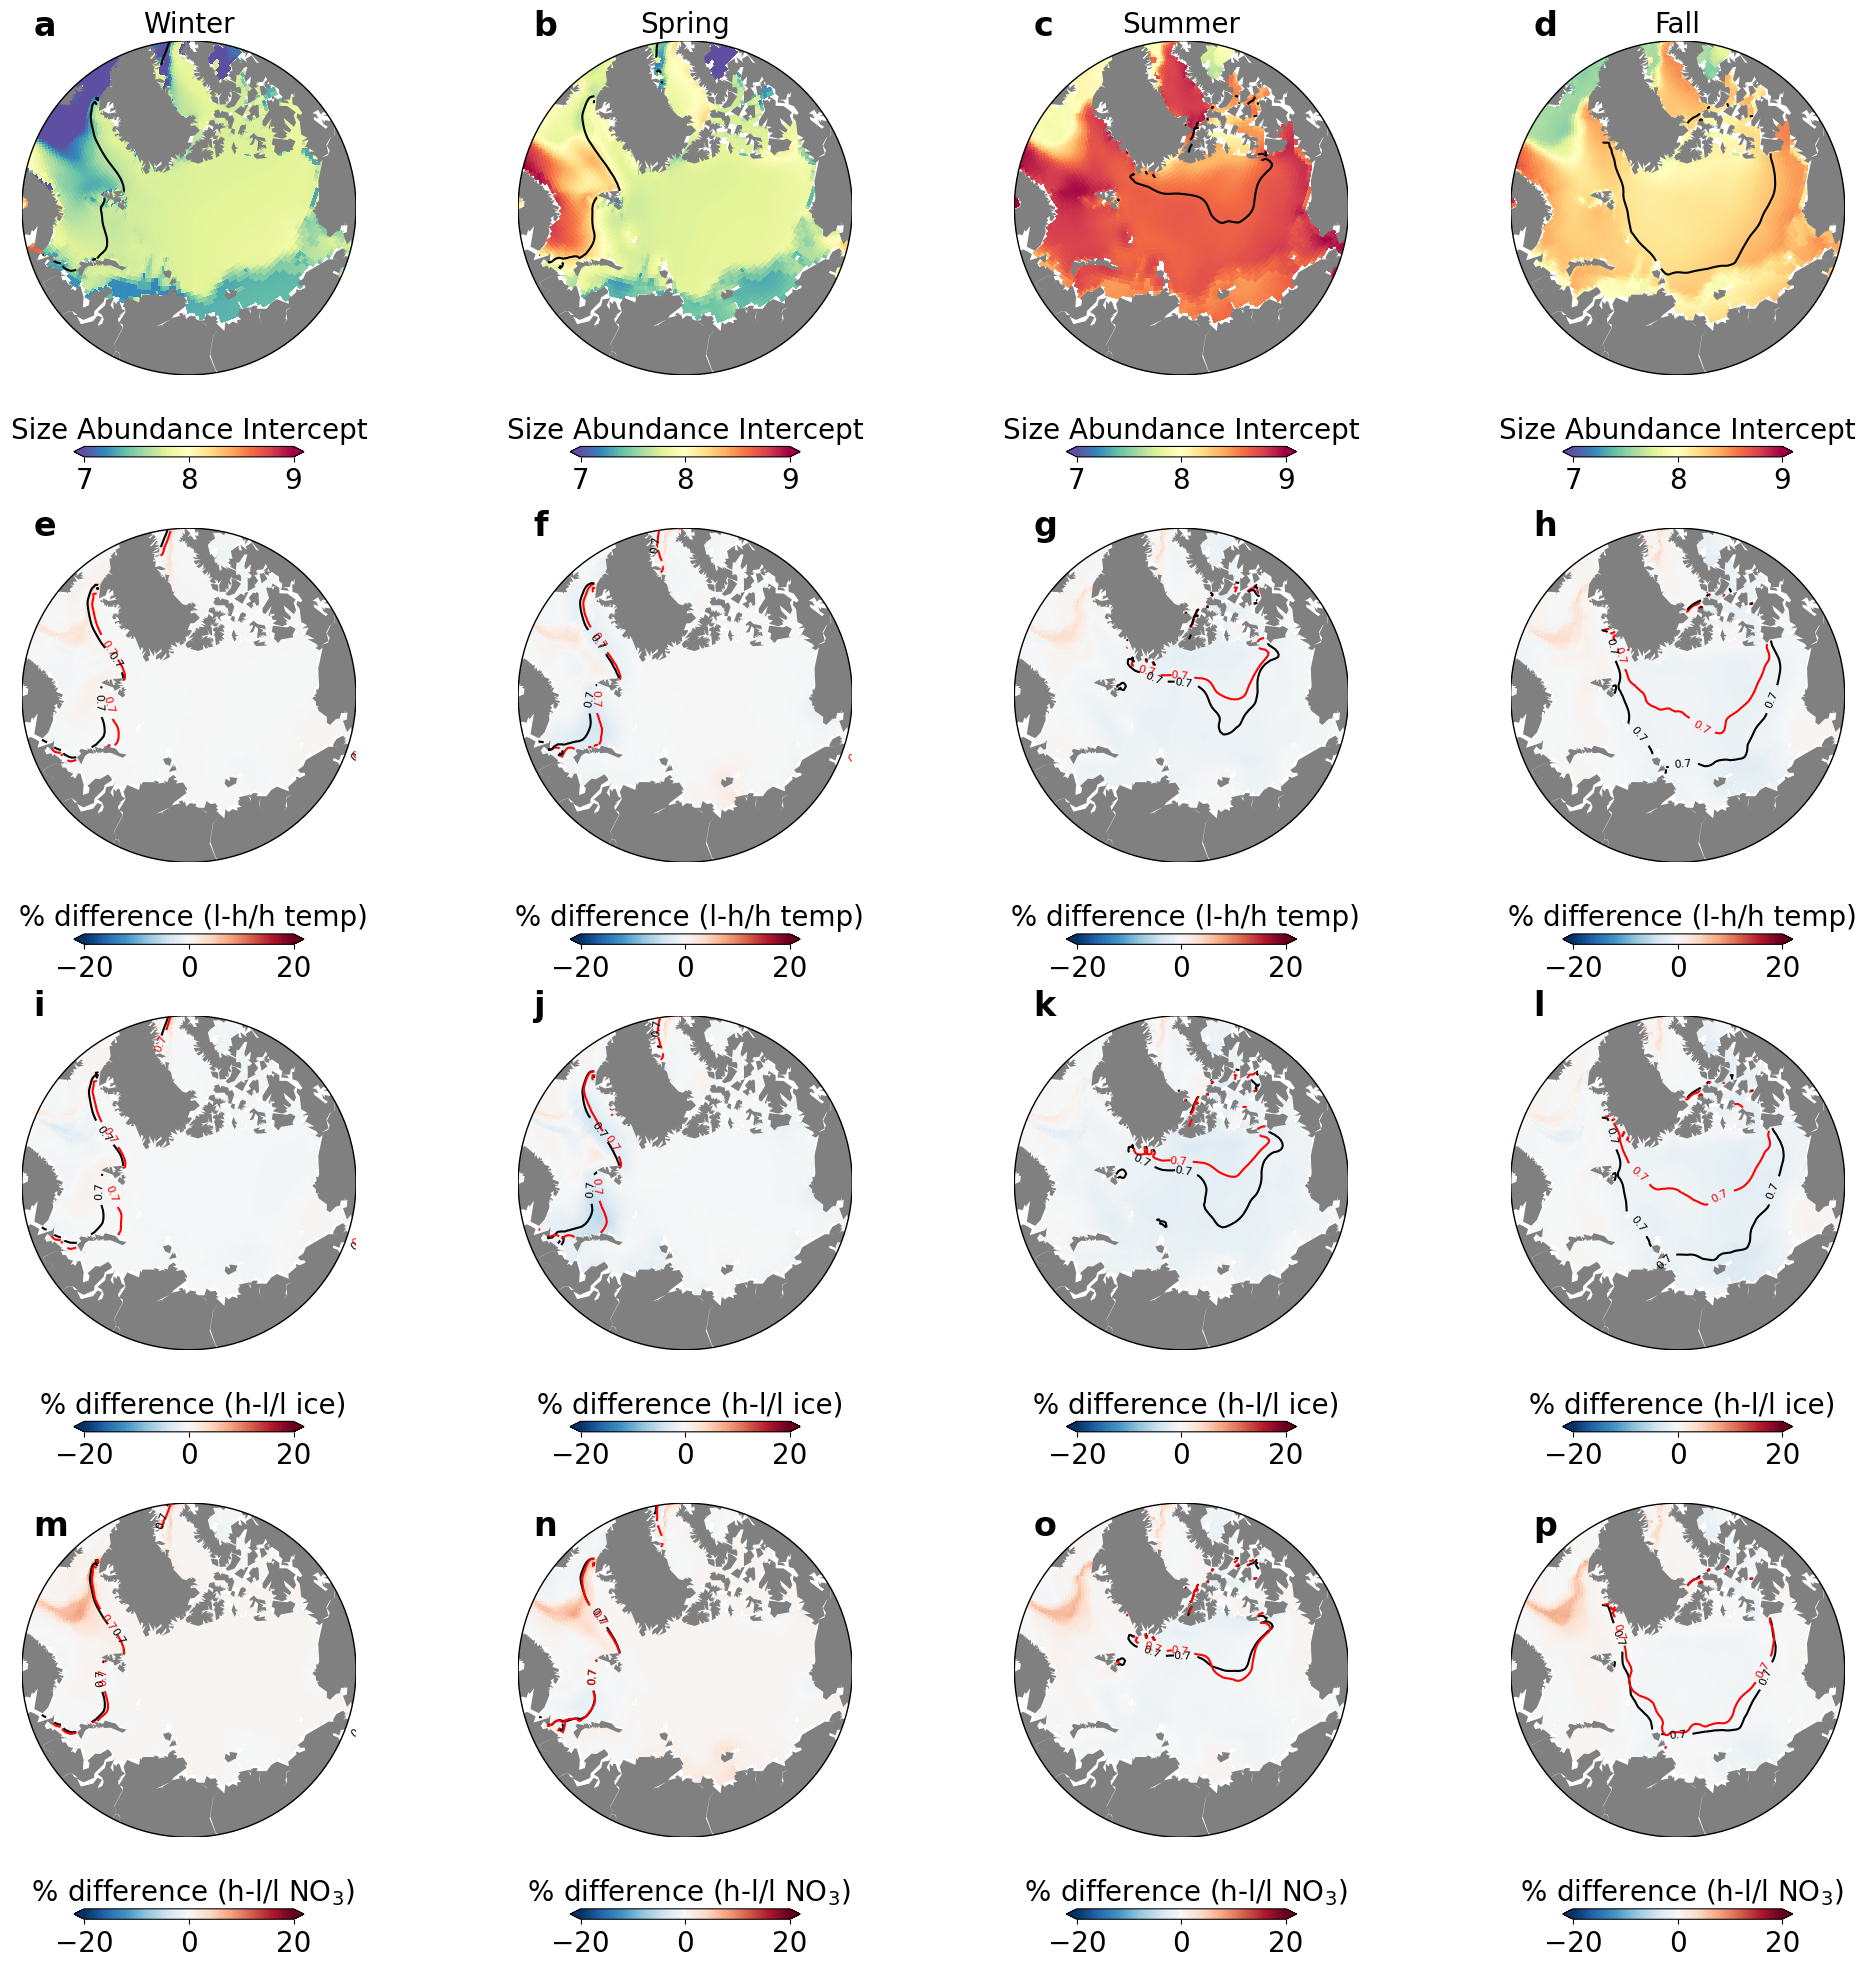

In [28]:
from mpl_toolkits.basemap import Basemap
lev = np.arange(0, 1, 0.01)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.5)
fig = plt.figure(figsize=(20, 20))

# ------------------------------------------------
########## Seasonal Changes #############
# ------------------------------------------------
#  62-year average  

# Winter TLeq = 3 (62yr average)
ax = fig.add_subplot(4, 4, 1)
lon, lat, winter = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, np.nanmean(ypp_surface_62yr[:,list(range(2)) + [-1],:,:,1],axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, winter, cmap='Spectral_r', vmin = 7, vmax = 9);
tlon, tlat, winter_ice = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(ds_winter_avg.ECOSYS_IFRAC, axis=0))
cs = m.contour(x, y, winter_ice,levels = [0.7],colors='k');
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title('Size Abundance Intercept', fontsize=20)
cb.ax.tick_params(labelsize=20)
ax.set_title('Winter', fontsize =20)

# Spring TLeq = 3, (62yr average)
ax = fig.add_subplot(4, 4, 2)
lon, lat, spring = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, np.nanmean(ypp_surface_62yr[:,2:5,:,:,1],axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, spring, cmap='Spectral_r', vmin = 7, vmax = 9);
tlon, tlat, spring_ice = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(ds_spring_avg.ECOSYS_IFRAC, axis=0))
cs = m.contour(x, y, spring_ice,levels = [0.7],colors='k');
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title('Size Abundance Intercept', fontsize=20)
cb.ax.tick_params(labelsize=20)
ax.set_title('Spring', fontsize =20)

# Summer TLeq = 3, (62 yr average)
ax = fig.add_subplot(4, 4, 3)
lon, lat, summer = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, np.nanmean(ypp_surface_62yr[:,5:8,:,:,1],axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, summer, cmap='Spectral_r', vmin = 7, vmax = 9);
tlon, tlat, summer_ice = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(ds_summer_avg.ECOSYS_IFRAC, axis=0))
cs = m.contour(x, y, summer_ice,levels = [0.7],colors='k');
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title('Size Abundance Intercept', fontsize=20)
cb.ax.tick_params(labelsize=20)
ax.set_title('Summer', fontsize =20)

# Fall TLeq = 3, (62 yr average)
ax = fig.add_subplot(4, 4, 4)
lon, lat, fall = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, np.nanmean(ypp_surface_62yr[:,8:11,:,:,1],axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, fall, cmap='Spectral_r',vmin = 7, vmax = 9);
tlon, tlat, fall_ice = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(ds_fall_avg.ECOSYS_IFRAC, axis=0))
cs = m.contour(x, y, fall_ice,levels = [0.7],colors='k');
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title('Size Abundance Intercept', fontsize=20)
cb.ax.tick_params(labelsize=20)
ax.set_title('Fall', fontsize =20)

# ------------------------------------------------
########## Interannual Differences #############
# ------------------------------------------------

# Winter, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 5)
winter_temp_diff = ((np.nanmean(cold_years[:,:,list(range(2)) + [-1],:,:,1], axis=(0,1,2))-np.nanmean(warm_years[:,:,list(range(2)) + [-1],:,:,1], axis=(0,1,2)))/np.nanmean(warm_years[:,:,list(range(2)) + [-1],:,:,1], axis=(0,1,2)))*100
lon, lat, w_diff = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, winter_temp_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=-20,vmax=20);
tlon, tlat, ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_temp_years_winter_ice,axis=(0,1)))
tlon, tlat, ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_temp_years_winter_ice,axis=(0,1)))
cs = m.contour(x, y, ice_high,levels = [0.7],colors='red'); # Red is ice fraction in warmer years (so it would be lower ice fraction). 
css = m.contour(x, y, ice_low,levels = [0.7],colors='k'); # Black is ice fraction in colder years (so it would be higher ice fraction). 
lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
lb = plt.clabel(css, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (l-h/h temp)', fontsize=20)
cb.ax.tick_params(labelsize=20)

# Spring, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 6)
spring_temp_diff = ((np.nanmean(cold_years[:,:,2:5,:,:,1], axis=(0,1,2))-np.nanmean(warm_years[:,:,2:5,:,:,1], axis=(0,1,2)))/np.nanmean(warm_years[:,:,2:5,:,:,1], axis=(0,1,2)))*100
lon, lat, sp_diff = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, spring_temp_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=-20,vmax=20);
tlon, tlat, ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_temp_years_spring_ice,axis=(0,1)))
tlon, tlat, ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_temp_years_spring_ice,axis=(0,1)))
cs = m.contour(x, y, ice_high,levels = [0.7],colors='red'); # Red is ice fraction in warmer years (so it would be lower ice fraction). 
css = m.contour(x, y, ice_low,levels = [0.7],colors='k'); # Black is ice fraction in colder years (so it would be higher ice fraction). 
lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
lb = plt.clabel(css, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (l-h/h temp)', fontsize=20)
cb.ax.tick_params(labelsize=20)

# Summer, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 7)
summer_temp_diff = ((np.nanmean(cold_years[:,:,5:8,:,:,1], axis=(0,1,2))-np.nanmean(warm_years[:,:,5:8,:,:,1], axis=(0,1,2)))/np.nanmean(warm_years[:,:,5:8,:,:,1], axis=(0,1,2)))*100
lon, lat, s_diff = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, summer_temp_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=-20,vmax=20);
tlon, tlat, ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_temp_years_summer_ice,axis=(0,1)))
tlon, tlat, ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_temp_years_summer_ice,axis=(0,1)))
cs = m.contour(x, y, ice_high,levels = [0.7],colors='red'); # Red is ice fraction in warmer years (so it would be lower ice fraction). 
css = m.contour(x, y, ice_low,levels = [0.7],colors='k'); # Black is ice fraction in colder years (so it would be higher ice fraction). 
lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
lb = plt.clabel(css, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (l-h/h temp)', fontsize=20)
cb.ax.tick_params(labelsize=20)

# Fall, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 8)
fall_temp_diff = ((np.nanmean(cold_years[:,:,8:11,:,:,1], axis=(0,1,2))-np.nanmean(warm_years[:,:,8:11,:,:,1], axis=(0,1,2)))/np.nanmean(warm_years[:,:,8:11,:,:,1], axis=(0,1,2)))*100
lon, lat, f_diff = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, fall_temp_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=-20,vmax=20);
tlon, tlat, ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_temp_years_fall_ice,axis=(0,1)))
tlon, tlat, ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_temp_years_fall_ice,axis=(0,1)))
cs = m.contour(x, y, ice_high,levels = [0.7],colors='red'); # Red is ice fraction in warmer years (so it would be lower ice fraction). 
css = m.contour(x, y, ice_low,levels = [0.7],colors='k'); # Black is ice fraction in colder years (so it would be higher ice fraction). 
lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
lb = plt.clabel(css, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (l-h/h temp)', fontsize=20)
cb.ax.tick_params(labelsize=20)

## Ice Fraction

# Winter, % difference of catch from high and low ice fraction  years. 
ax = fig.add_subplot(4, 4, 9)
winter_ice_diff = ((np.nanmean(high_ice_years[:,:,list(range(2)) + [-1],:,:,1], axis=(0,1,2))-np.nanmean(low_ice_years[:,:,list(range(2)) + [-1],:,:,1], axis=(0,1,2)))/np.nanmean(low_ice_years[:,:,list(range(2)) + [-1],:,:,1], axis=(0,1,2)))*100
lon, lat, w_diff = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, winter_ice_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=-20,vmax=20);
tlon, tlat, ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_ice_years_winter_ice,axis=(0,1)))
tlon, tlat, ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_ice_years_winter_ice,axis=(0,1)))
cs = m.contour(x, y, ice_high,levels = [0.7],colors='k'); # ice in high ice years 
css = m.contour(x, y, ice_low,levels = [0.7],colors='red'); # ice in low ice years 
lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
lb = plt.clabel(css, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (h-l/l ice)', fontsize=20)
cb.ax.tick_params(labelsize=20)

# Spring, % difference of catch from high and low ice fraction years. 
ax = fig.add_subplot(4, 4, 10)
spring_ice_diff = ((np.nanmean(high_ice_years[:,:,2:5,:,:,1], axis=(0,1,2))-np.nanmean(low_ice_years[:,:,2:5,:,:,1], axis=(0,1,2)))/np.nanmean(low_ice_years[:,:,2:5,:,:,1], axis=(0,1,2)))*100
lon, lat, sp_diff = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, spring_ice_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=-20,vmax=20);
tlon, tlat, ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_ice_years_spring_ice,axis=(0,1)))
tlon, tlat, ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_ice_years_spring_ice,axis=(0,1)))
cs = m.contour(x, y, ice_high,levels = [0.7],colors='k'); # ice in high ice years 
css = m.contour(x, y, ice_low,levels = [0.7],colors='red'); # ice in low ice years 
lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
lb = plt.clabel(css, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (h-l/l ice)', fontsize=20)
cb.ax.tick_params(labelsize=20)

# Summer, % difference of catch from high and low ice fraction  years. 
ax = fig.add_subplot(4, 4, 11)
summer_ice_diff = ((np.nanmean(high_ice_years[:,:,5:8,:,:,1], axis=(0,1,2))-np.nanmean(low_ice_years[:,:,5:8,:,:,1], axis=(0,1,2)))/np.nanmean(low_ice_years[:,:,5:8,:,:,1], axis=(0,1,2)))*100
lon, lat, s_diff = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, summer_ice_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=-20,vmax=20);
tlon, tlat, ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_ice_years_summer_ice,axis=(0,1)))
tlon, tlat, ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_ice_years_summer_ice,axis=(0,1)))
cs = m.contour(x, y, ice_high,levels = [0.7],colors='k'); # ice in high ice years 
css = m.contour(x, y, ice_low,levels = [0.7],colors='red'); # ice in low ice years 
lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
lb = plt.clabel(css, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (h-l/l ice)', fontsize=20)
cb.ax.tick_params(labelsize=20)

# Fall, % difference of catch from high and low ice fraction  years. 
ax = fig.add_subplot(4, 4, 12)
fall_ice_diff = ((np.nanmean(high_ice_years[:,:,8:11,:,:,1], axis=(0,1,2))-np.nanmean(low_ice_years[:,:,8:11,:,:,1], axis=(0,1,2)))/np.nanmean(low_ice_years[:,:,8:11,:,:,1], axis=(0,1,2)))*100
lon, lat, f_diff = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, fall_ice_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=-20,vmax=20);
tlon, tlat, ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_ice_years_fall_ice,axis=(0,1)))
tlon, tlat, ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_ice_years_fall_ice,axis=(0,1)))
cs = m.contour(x, y, ice_high,levels = [0.7],colors='k'); # ice in high ice years 
css = m.contour(x, y, ice_low,levels = [0.7],colors='red'); # ice in low ice years 
lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
lb = plt.clabel(css, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (h-l/l ice)', fontsize=20)
cb.ax.tick_params(labelsize=20)


# Winter, % difference of catch from high and low NO$_3$  years. 
ax = fig.add_subplot(4, 4, 13)
winter_no3_diff = ((np.nanmean(high_no3_years[:,:,list(range(2)) + [-1],:,:,1], axis=(0,1,2))-np.nanmean(low_no3_years[:,:,list(range(2)) + [-1],:,:,1], axis=(0,1,2)))/np.nanmean(low_no3_years[:,:,list(range(2)) + [-1],:,:,1], axis=(0,1,2)))*100
lon, lat, w_diff = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, winter_no3_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=-20,vmax=20);
tlon, tlat, ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_no3_years_winter_ice,axis=(0,1)))
tlon, tlat, ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_no3_years_winter_ice,axis=(0,1)))
cs = m.contour(x, y, ice_high,levels = [0.7],colors='k'); # ice in high no3 years 
css = m.contour(x, y, ice_low,levels = [0.7],colors='red'); # ice in low no3 years 
lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
lb = plt.clabel(css, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (h-l/l NO$_3$)', fontsize=20)
cb.ax.tick_params(labelsize=20)

# Spring, % difference of catch from high and low NO$_3$ years. 
ax = fig.add_subplot(4, 4, 14)
spring_no3_diff = ((np.nanmean(high_no3_years[:,:,2:5,:,:,1], axis=(0,1,2))-np.nanmean(low_no3_years[:,:,2:5,:,:,1], axis=(0,1,2)))/np.nanmean(low_no3_years[:,:,2:5,:,:,1], axis=(0,1,2)))*100
lon, lat, sp_diff = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, spring_no3_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=-20,vmax=20);
tlon, tlat, ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_no3_years_spring_ice,axis=(0,1)))
tlon, tlat, ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_no3_years_spring_ice,axis=(0,1)))
cs = m.contour(x, y, ice_high,levels = [0.7],colors='k'); # ice in high no3 years 
css = m.contour(x, y, ice_low,levels = [0.7],colors='red'); # ice in low no3 years 
lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
lb = plt.clabel(css, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (h-l/l NO$_3$)', fontsize=20)
cb.ax.tick_params(labelsize=20)

# Summer, % difference of catch from high and low NO$_3$  years. 
ax = fig.add_subplot(4, 4, 15)
summer_no3_diff = ((np.nanmean(high_no3_years[:,:,5:8,:,:,1], axis=(0,1,2))-np.nanmean(low_no3_years[:,:,5:8,:,:,1], axis=(0,1,2)))/np.nanmean(low_no3_years[:,:,5:8,:,:,1], axis=(0,1,2)))*100
lon, lat, s_diff = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, summer_no3_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=-20,vmax=20);
tlon, tlat, ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_no3_years_summer_ice,axis=(0,1)))
tlon, tlat, ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_no3_years_summer_ice,axis=(0,1)))
cs = m.contour(x, y, ice_high,levels = [0.7],colors='k'); # ice in high no3 years 
css = m.contour(x, y, ice_low,levels = [0.7],colors='red'); # ice in low no3 years 
lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
lb = plt.clabel(css, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (h-l/l NO$_3$)', fontsize=20)
cb.ax.tick_params(labelsize=20)

# Fall, % difference of catch from high and low NO$_3$  years. 
ax = fig.add_subplot(4, 4, 16)
fall_no3_diff = ((np.nanmean(high_no3_years[:,:,8:11,:,:,1], axis=(0,1,2))-np.nanmean(low_no3_years[:,:,8:11,:,:,1], axis=(0,1,2)))/np.nanmean(low_no3_years[:,:,8:11,:,:,1], axis=(0,1,2)))*100
lon, lat, f_diff = adjust_pop_grid(ds_summer.TLONG, ds_summer.TLAT, fall_no3_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=-20,vmax=20);
tlon, tlat, ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_no3_years_fall_ice,axis=(0,1)))
tlon, tlat, ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_no3_years_fall_ice,axis=(0,1)))
cs = m.contour(x, y, ice_high,levels = [0.7],colors='k'); # ice in high no3 years 
css = m.contour(x, y, ice_low,levels = [0.7],colors='red'); # ice in low no3 years 
lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
lb = plt.clabel(css, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.tick_params(labelsize=20)
cb.ax.set_title(' % difference (h-l/l NO$_3$)', fontsize=20)

fig.text(0.05, 0.98, 'a',fontsize=24, fontweight='bold')
fig.text(0.3, 0.98, 'b',fontsize=24, fontweight='bold')
fig.text(0.55, 0.98, 'c',fontsize=24, fontweight='bold')
fig.text(0.80, 0.98, 'd',fontsize=24, fontweight='bold')
fig.text(0.05, 0.73, 'e',fontsize=24, fontweight='bold')
fig.text(0.3, 0.73, 'f',fontsize=24, fontweight='bold')
fig.text(0.55, 0.73, 'g',fontsize=24, fontweight='bold')
fig.text(0.80, 0.73, 'h',fontsize=24, fontweight='bold')
fig.text(0.05, 0.49, 'i',fontsize=24, fontweight='bold')
fig.text(0.3, 0.49, 'j',fontsize=24, fontweight='bold')
fig.text(0.55, 0.49, 'k',fontsize=24, fontweight='bold')
fig.text(0.80, 0.49, 'l',fontsize=24, fontweight='bold')
fig.text(0.05, 0.23, 'm',fontsize=24, fontweight='bold')
fig.text(0.3, 0.23, 'n',fontsize=24, fontweight='bold')
fig.text(0.55, 0.23, 'o',fontsize=24, fontweight='bold')
fig.text(0.80, 0.23, 'p',fontsize=24, fontweight='bold')

plt.tight_layout()

fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/quarterly_size_abundance_intercept_interannual.png',dpi=600, bbox_inches='tight')

### Extra figure: Reduced to only summer and winter for committee meeting 

In [ ]:
from mpl_toolkits.basemap import Basemap
lev = np.arange(0, 1, 0.01)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.5)
fig = plt.figure(figsize=(10, 20))

# ------------------------------------------------
########## Seasonal Changes #############
# ------------------------------------------------
#  62-year average 

# Winter TLeq = 3 (62yr average)
ax = fig.add_subplot(4, 2, 1)
lon, lat, winter = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(ypp_surface_62yr[:,list(range(2)) + [-1],:,:,0],axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, winter, cmap='Spectral_r', vmin = -1, vmax = -0.6);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title('Size abundance slope', fontsize=20)
cb.ax.tick_params(labelsize=20)
ax.set_title('Winter', fontsize =20)



# Summer TLeq = 3, (62 yr average)
ax = fig.add_subplot(4, 2, 2)
lon, lat, summer = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(ypp_surface_62yr[:,5:8,:,:,0],axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, summer, cmap='Spectral_r', vmin = -1, vmax = -0.6);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title('Size abundance slope', fontsize=20)
ax.set_title('Summer', fontsize =20)
cb.ax.tick_params(labelsize=20)

# ------------------------------------------------
########## Interannual Differences #############
# ------------------------------------------------

# Winter, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 2, 3)
winter_temp_diff = ((np.nanmean(cold_years[:,:,list(range(2)) + [-1],:,:,0], axis=(0,1,2))-np.nanmean(warm_years[:,:,list(range(2)) + [-1],:,:,0], axis=(0,1,2)))/np.nanmean(warm_years[:,:,list(range(2)) + [-1],:,:,0], axis=(0,1,2)))*100
lon, lat, w_diff = adjust_pop_grid(ds.TLONG, ds.TLAT, winter_temp_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=-20,vmax=20);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (cold-warm/warm)', fontsize=20)
cb.ax.tick_params(labelsize=20)

# Summer, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 2, 4)
summer_temp_diff = ((np.nanmean(cold_years[:,:,5:8,:,:,0], axis=(0,1,2))-np.nanmean(warm_years[:,:,5:8,:,:,0], axis=(0,1,2)))/np.nanmean(warm_years[:,:,5:8,:,:,0], axis=(0,1,2)))*100
lon, lat, s_diff = adjust_pop_grid(ds.TLONG, ds.TLAT, summer_temp_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=-20,vmax=20);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (cold-warm/warm)', fontsize=20)
cb.ax.tick_params(labelsize=20)

## Ice Fraction

# Winter, % difference of catch from high and low ice fraction  years. 
ax = fig.add_subplot(4, 2, 5)
winter_ice_diff = ((np.nanmean(high_ice_years[:,:,list(range(2)) + [-1],:,:,0], axis=(0,1,2))-np.nanmean(low_ice_years[:,:,list(range(2)) + [-1],:,:,0], axis=(0,1,2)))/np.nanmean(low_ice_years[:,:,list(range(2)) + [-1],:,:,0], axis=(0,1,2)))*100
lon, lat, w_diff = adjust_pop_grid(ds.TLONG, ds.TLAT, winter_ice_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=-20,vmax=20);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (high-low/low ice)', fontsize=20)
cb.ax.tick_params(labelsize=20)

# Summer, % difference of catch from high and low ice fraction  years. 
ax = fig.add_subplot(4, 2, 6)
summer_ice_diff = ((np.nanmean(high_ice_years[:,:,5:8,:,:,0], axis=(0,1,2))-np.nanmean(low_ice_years[:,:,5:8,:,:,0], axis=(0,1,2)))/np.nanmean(low_ice_years[:,:,5:8,:,:,0], axis=(0,1,2)))*100
lon, lat, s_diff = adjust_pop_grid(ds.TLONG, ds.TLAT, summer_ice_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=-20,vmax=20);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (high-low/low ice)', fontsize=20)
cb.ax.tick_params(labelsize=20)

# Winter, % difference of catch from high and low NO$_3$  years. 
ax = fig.add_subplot(4, 2, 7)
winter_no3_diff = ((np.nanmean(high_no3_years[:,:,list(range(2)) + [-1],:,:,0], axis=(0,1,2))-np.nanmean(low_no3_years[:,:,list(range(2)) + [-1],:,:,0], axis=(0,1,2)))/np.nanmean(low_no3_years[:,:,list(range(2)) + [-1],:,:,0], axis=(0,1,2)))*100
lon, lat, w_diff = adjust_pop_grid(ds.TLONG, ds.TLAT, winter_no3_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=-20,vmax=20);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (high-low/low NO$_3$)', fontsize=20)
cb.ax.tick_params(labelsize=20)

# Summer, % difference of catch from high and low NO$_3$  years. 
ax = fig.add_subplot(4, 2, 8)
summer_no3_diff = ((np.nanmean(high_no3_years[:,:,5:8,:,:,0], axis=(0,1,2))-np.nanmean(low_no3_years[:,:,5:8,:,:,0], axis=(0,1,2)))/np.nanmean(low_no3_years[:,:,5:8,:,:,0], axis=(0,1,2)))*100
lon, lat, s_diff = adjust_pop_grid(ds.TLONG, ds.TLAT, summer_no3_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=-20,vmax=20);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (high-low/low NO$_3$)', fontsize=20)
cb.ax.tick_params(labelsize=20)

plt.tight_layout()

#fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/quarterly_size_abundance_slope_interannual_committee_meeting.png',dpi=600, bbox_inches='tight')